In [1]:
import matplotlib.pyplot as plt
import tools.dataTools as dt
from constants import Constants
import figure_params
import numpy as np 
import seaborn as sns
import scipy
import pandas as pd
import math
from tools.test import test_model
import os

figure_params.set_rc_params()
figure_params.setup_directories()

SUBFIG_DIR = Constants.FIG_FOLDER + 'figS5_ranges/'
if not os.path.exists(SUBFIG_DIR):
    os.makedirs(SUBFIG_DIR)

#run simulations for figure, will take a while to run
import subprocess
os.chdir(Constants.PROJ_DIR)
# subprocess.run(["bash", "simulation/fig_simulations/Sfig_ranges_sims.sh"]) #uncomment code to make datasets if not made yet

import warnings
warnings.filterwarnings("ignore")

In [2]:
repertoires = Constants.UNIS
seed_ex = Constants.SEED_EX
sim_set = 'uni_rad'
seeds = Constants.SEEDS
perturbation = 'rotation'
pert_param = 10.0
pert_set = 'v1'

#### Generalization

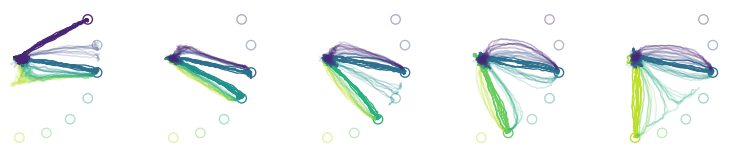

In [3]:
fig, axs = plt.subplots(ncols = 5, sharey=True, figsize = (2*5,2))
for i,r in enumerate(['-30_10','10_30','10_50','10_70','10_90']):
    start, end = [-int(x) for x in r.split('_')]
    rep = f'uni_2movs_{r}'
    outdir = dt.get_outdir(seed_ex, 'uni_rad', rep)
    datadir,_,output,_ = test_model(outdir, datafile = 'uni_7movs_-30_90_rad')

    # get data
    datname = Constants.PROJ_DIR + datadir
    data = np.load(datname+'.npy',allow_pickle = True).item()['test_set1']    
    task_info = np.array(data['target_param'])
    task_info = [(x - 2*math.pi) if x > math.pi else x for x in task_info]
    task_info = np.rint(np.degrees(task_info))

    #plotting
    colormap = dt.get_colormap(task_info,'viridis_r')

    #choose random trials to plot
    np.random.seed(1234)
    for target in np.unique(task_info):
        target_idx = np.random.choice(np.where(task_info == target)[0], 10)
        output_ = output[target_idx]

        # graph trajectory positions
        known = ((target == start) or (target == end)) #known movements

        for j in range(output_.shape[0]):
            axs[i].plot(output_[j,:,0],output_[j,:,1], '.', c = colormap[target],
                    linestyle = '-', linewidth = 1, marker = None, alpha = 1.0 if known else 0.2)
        angle = math.radians(target)
        axs[i].scatter(8*math.cos(angle), 8*math.sin(angle), 
               facecolors = 'none', edgecolors = colormap[target], 
               s = 50, marker = 'o', linewidths = 1, alpha = 1.0 if known else 0.4)

    axs[i].set_aspect(1)
    axs[i].set_xlim([-1,10])
    axs[i].set_ylim([-10,5])
    axs[i].set_axis_off()

plt.savefig(SUBFIG_DIR+ f'generalization_output_{seed_ex}.pdf', format='pdf')

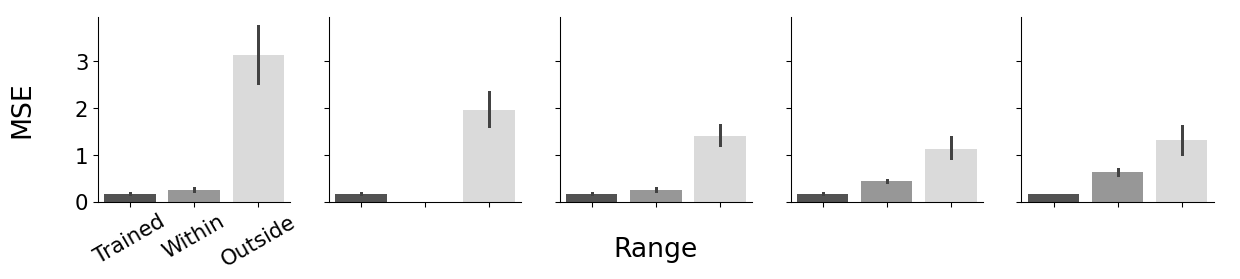

In [4]:
fig, axs = plt.subplots(ncols = 5, figsize = (3*5,2.5), sharey=True)

for i,r in enumerate(['-30_10','10_30','10_50','10_70','10_90']):
    start, end = [-int(x) for x in r.split('_')]
    mse_df = dt.get_testing_MSE_df(seeds, 'uni_rad', [f'uni_2movs_{r}'], 
    datafile = 'uni_7movs_-30_90_rad', by_target=True)
    mse_df['target_param'] = [(x - 2*math.pi) if x > math.pi else x for x in mse_df['target_param']]
    mse_df['target_param'] = np.rint(np.degrees(mse_df['target_param']))
    mse_df['group'] = ['Within' if (start > x > end)
                            else 'Outside' if ((start < x) or (x < end))
                            else 'Trained' for x in mse_df['target_param']]
    g = sns.barplot(data = mse_df, x = 'group', y ='mse', palette = 'Greys_r', ax = axs[i], order = ['Trained','Within', 'Outside'])
    g.set_xlabel('')
    g.set_ylabel('')
    if i == 0:
        g.set_xticklabels(g.get_xticklabels(), rotation = 30)
    else:
        g.set_xticklabels([])
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("Range")
plt.ylabel("MSE")
plt.savefig(SUBFIG_DIR+ 'generalization_mse.pdf', format='pdf',bbox_inches='tight')

#### Loss

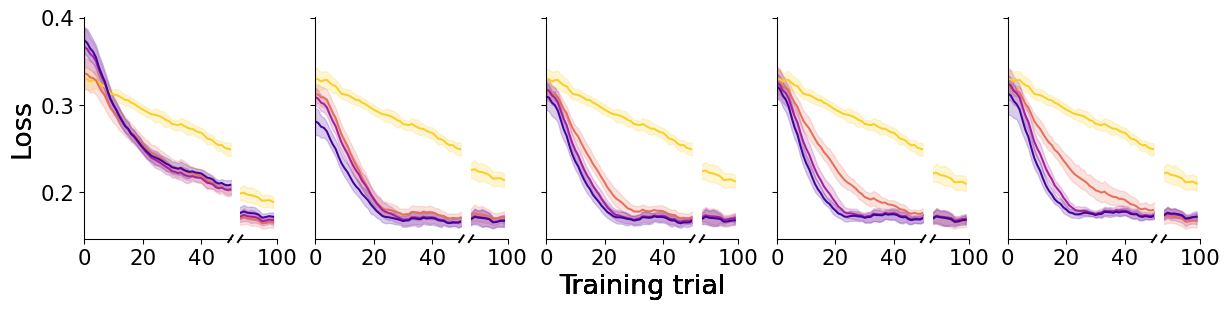

In [5]:
smooth = True
#rad adaptation, diff ranges
fig, axs = plt.subplots(ncols=5, nrows=1, sharey= True, figsize = (3*5,3))
for i,r in enumerate(['-30_10','10_30','10_50','10_70','10_90']):
    reps = [x.replace('10_50', r) for x in Constants.UNIS]

    _,_, params = dt.graph_loss_broken_axis(seeds, 'uni_rad', reps, 
        perturbation, pert_param, pert_set, 
        smooth=smooth, rel_loss = False, fig_ax = (fig, axs[i]))

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("Training trial")
plt.ylabel("Loss")
plt.savefig(SUBFIG_DIR + '/' + f"loss_ranges.pdf", format='pdf', bbox_inches='tight')

#### Decay constant

In [6]:
#exponential function
def exp_func(t, A, K, C):
    return A * np.exp(K * t) + C

smooth = True

#get repertoires
all_reps = Constants.UNIS
for r in (['-30_10','10_30','10_50','10_70','10_90']):
    reps = [x.replace('10_50', r) for x in Constants.UNIS]
    all_reps= all_reps + reps

rows_list = []
colormap = dt.get_colormap(reps, Constants.REPERTOIRE_CMAP)
for seed in seeds:
    for repertoire in all_reps:
        try:
            loss = dt.get_loss(seed, sim_set, repertoire, perturbation, pert_param, pert_set, smooth = smooth)
        except:
            print('failed', seed, sim_set, repertoire)
            continue
        t = np.arange(1,len(loss)+1)

        #exponential fit
        p0 = (0.1,-0.1,0.2) # starting search koefs
        opt, pcov =  scipy.optimize.curve_fit(exp_func, t, loss, p0)
        A, K, C = opt
        fit_y = exp_func(t, A, K, C)

        temp = {
            'seed': seed,
            'sim_set': sim_set,
            'repertoire': repertoire,
            'perturbation': perturbation,
            'pert_param': pert_param,
            'pert_set': pert_set,
            'decay': K
        }
        rows_list.append(temp)

decay_df = pd.DataFrame(rows_list)

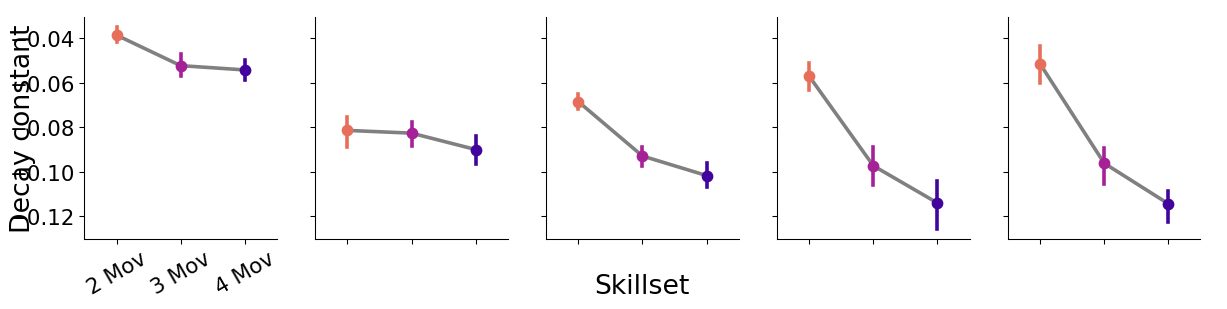

In [7]:
#plot decay rate
fig, axs = plt.subplots(ncols = 5, figsize = (3*5,3), sharey=True)
for i,r in enumerate(['-30_10','10_30','10_50','10_70','10_90']):
    reps = [x.replace('10_50', r) for x in Constants.UNIS]
    reps = reps[1:]
    
    df = decay_df[(decay_df.sim_set == sim_set)]

    #plotting 
    g = dt.pointplot_across_repertoires(df, reps, 'decay', ax = axs[i], abr_labels=False)

    g.lines[0].set_zorder(2)

    for l  in g.lines[1:]:
        l.set_zorder(5)
    for c  in g.collections:
        c.set_zorder(3)

    g.set_xlabel('')
    g.set_ylabel('')
    if i == 0:
        g.set_xticklabels(['2 Mov', '3 Mov', '4 Mov'], rotation = 30)
    else:
        g.set_xticklabels([])

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("Skillset")
plt.ylabel("Decay constant")
plt.savefig(SUBFIG_DIR + f"decay_ranges.pdf", format='pdf', bbox_inches='tight')

# #stats for decay rate
# for measure in ['decay']:
#     for i, 1 in enumerate(reps):
#         for j, 2 in enumerate(reps[i+1:]):
#             a = df[(df.repertoire == 1)]
#             b = df[(df.repertoire == 2)]
#             a_measure = a[measure].values
#             b_measure = b[measure].values

#             #check normality: this is normal
#             # print(scipy.stats.shapiro(a_measure), scipy.stats.shapiro(b_measure))

#             _, pnorm = scipy.stats.ttest_rel(a_measure, b_measure)
#             print(measure, '\t', abr_dict[1], '\t', abr_dict[2], '\t', pnorm)
#     print('\n') 